In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Creating dataset.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train_images/2d305cc3a.jpg  
  inflating: /content/data/train_images/2d31a59f2.jpg  
  inflating: /content/data/train_images/2d31c108a.jpg  
  inflating: /content/data/train_images/2d321711c.jpg  
  inflating: /content/data/train_images/2d338ba7c.jpg  
  inflating: /content/data/train_images/2d35b5518.jpg  
  inflating: /content/data/train_images/2d36dd423.jpg  
  inflating: /content/data/train_images/2d386cbb2.jpg  
  inflating: /content/data/train_images/2d3a2a31e.jpg  
  inflating: /content/data/train_images/2d3eee0e2.jpg  
  inflating: /content/data/train_images/2d402a054.jpg  
  inflating: /content/data/train_images/2d4100495.jpg  
  inflating: /content/data/train_images/2d412a8b7.jpg  
  inflating: /content/data/train_images/2d4240f1c.jpg  
  inflating: /content/data/train_images/2d42828e3.jpg  
  inflating: /content/data/train_images/2d44541ea.jpg  
  inflating: /content/data/train_images/2d458c653.jpg

In [3]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from os.path import join
from keras.losses import binary_crossentropy
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_ubyte
import tensorflow as tf
from IPython.display import clear_output

In [4]:
DATA_PATH   = 'data/'
TRAIN_PATH  = DATA_PATH+'train_images/'
TEST_PATH   = DATA_PATH+'train_images/' 
IMG_SIZE    = (768, 768)
INPUT_SHAPE = (768, 768, 3)
TARGET_SIZE = (384, 384)
TARGET_SIZE_RGB = (384, 384, 3)
BATCH_SIZE  = 48
EPOCHS      = 100

In [5]:
train_df = pd.read_csv('train_file.csv')

In [6]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [7]:
def get_mask(img_id, df):
  img = masks_as_image(df.query('ImageId=="'+img_id+'"')['EncodedPixels'])
  img = resize(img, TARGET_SIZE, mode='constant', preserve_range=True)
  return img 

In [8]:
def get_image(image_name):
    img = imread(TRAIN_PATH + image_name)
    img = resize(img, (384, 384))
    return img_as_ubyte(img)

In [9]:
get_image('4b53ed7ff.jpg')

array([[[ 4, 40, 54],
        [ 3, 39, 52],
        [ 6, 42, 54],
        ...,
        [ 2, 36, 46],
        [ 3, 37, 47],
        [ 1, 35, 45]],

       [[ 4, 40, 53],
        [ 4, 40, 52],
        [ 5, 41, 53],
        ...,
        [ 6, 40, 50],
        [ 2, 36, 46],
        [ 0, 34, 44]],

       [[ 6, 42, 54],
        [ 5, 41, 53],
        [ 5, 41, 53],
        ...,
        [ 4, 38, 48],
        [ 2, 36, 46],
        [ 1, 35, 45]],

       ...,

       [[ 4, 38, 50],
        [ 3, 37, 49],
        [ 0, 34, 46],
        ...,
        [ 4, 38, 49],
        [ 1, 35, 46],
        [ 1, 35, 46]],

       [[ 3, 37, 49],
        [ 3, 37, 49],
        [ 1, 34, 46],
        ...,
        [ 4, 38, 50],
        [ 2, 35, 47],
        [ 2, 35, 48]],

       [[ 3, 37, 49],
        [ 1, 35, 47],
        [ 0, 33, 45],
        ...,
        [ 5, 39, 51],
        [ 4, 36, 49],
        [ 3, 35, 48]]], dtype=uint8)

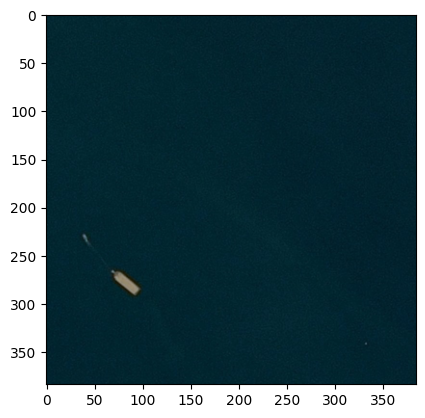

In [10]:
plt.imshow(get_image('4b53ed7ff.jpg'))

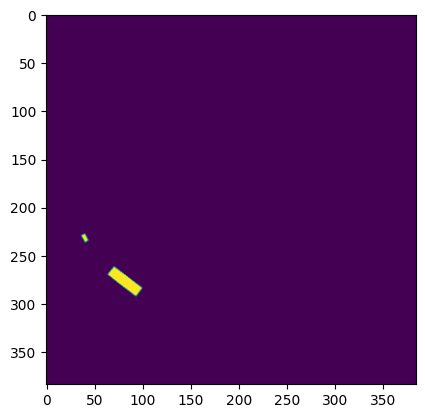

In [11]:
plt.imshow(get_mask('4b53ed7ff.jpg', train_df))

In [12]:
image = get_image('4b53ed7ff.jpg')
mask = get_mask('4b53ed7ff.jpg', train_df)

In [13]:
image

array([[[ 4, 40, 54],
        [ 3, 39, 52],
        [ 6, 42, 54],
        ...,
        [ 2, 36, 46],
        [ 3, 37, 47],
        [ 1, 35, 45]],

       [[ 4, 40, 53],
        [ 4, 40, 52],
        [ 5, 41, 53],
        ...,
        [ 6, 40, 50],
        [ 2, 36, 46],
        [ 0, 34, 44]],

       [[ 6, 42, 54],
        [ 5, 41, 53],
        [ 5, 41, 53],
        ...,
        [ 4, 38, 48],
        [ 2, 36, 46],
        [ 1, 35, 45]],

       ...,

       [[ 4, 38, 50],
        [ 3, 37, 49],
        [ 0, 34, 46],
        ...,
        [ 4, 38, 49],
        [ 1, 35, 46],
        [ 1, 35, 46]],

       [[ 3, 37, 49],
        [ 3, 37, 49],
        [ 1, 34, 46],
        ...,
        [ 4, 38, 50],
        [ 2, 35, 47],
        [ 2, 35, 48]],

       [[ 3, 37, 49],
        [ 1, 35, 47],
        [ 0, 33, 45],
        ...,
        [ 5, 39, 51],
        [ 4, 36, 49],
        [ 3, 35, 48]]], dtype=uint8)

In [14]:
mask.max()

1.0

In [15]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    masks = []
    images = []
    while True:
        np.random.shuffle(all_batches)
        for image, masks_df in all_batches:
            image, mask = [get_image(image)], [get_mask(image, masks_df)]
            images += image
            masks += mask
            if len(images)>=batch_size:
                yield np.stack(images, 0)/255.0, np.stack(masks, 0)
                masks, images=[], []

In [16]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = y_true_f.astype(np.float32)
    y_pred_f = y_pred_f.astype(np.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def get_unet_model(input_shape=(256, 256, 3), num_classes=1):

    def fire(x, filters, kernel_size, dropout):
        y1 = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        if dropout is not None:
            y1= Dropout(dropout)(y1)
        y2 = Conv2D(filters, kernel_size, activation='relu', padding='same')(y1)
        y3 = BatchNormalization(momentum=0.95)(y2)     
        return y3

    def fire_module(filters, kernel_size, dropout=0.1):
        return lambda x: fire(x, filters, kernel_size, dropout)

    def fire_up(x, filters, kernel_size, concat_layer):
        y1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        y2 = concatenate([y1, concat_layer])
        y3 = fire_module(filters, kernel_size, dropout=None)(y2)
        return y3

    def up_fire_module(filters, kernel_size, concat_layer):
        return lambda x: fire_up(x, filters, kernel_size, concat_layer)

    input_img = Input(shape=input_shape) #256

    down1 = fire_module(8, (3, 3))(input_img)
    pool1 = MaxPooling2D((2, 2))(down1)  #128

    down2 = fire_module(16, (3, 3))(pool1)
    pool2 = MaxPooling2D((2, 2))(down2) #64
    
    down3 = fire_module(32, (3, 3))(pool2)
    pool3 = MaxPooling2D((2, 2))(down3) #32
    
    down4 = fire_module(64, (3, 3))(pool3)
    pool4 = MaxPooling2D((2, 2))(down4) #16
    
    down5 = fire_module(128, (3, 3))(pool4)
    pool5 = MaxPooling2D((2, 2))(down5) # 8
    
    down6 = fire_module(256, (3, 3))(pool5) #center
    
    up6 = up_fire_module(128, (3, 3), down5)(down6) #16
    up7 = up_fire_module(64, (3, 3), down4)(up6) #32
    up8 = up_fire_module(32, (3, 3), down3)(up7) #64
    up9 = up_fire_module(16, (3, 3), down2)(up8) #128
    up10 = up_fire_module(8, (3, 3), down1)(up9) #256
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up10) 

    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])
    return model

In [17]:
model = get_unet_model(TARGET_SIZE_RGB)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 384, 384, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 384, 384, 8)  584         ['dropout[0][0]']            

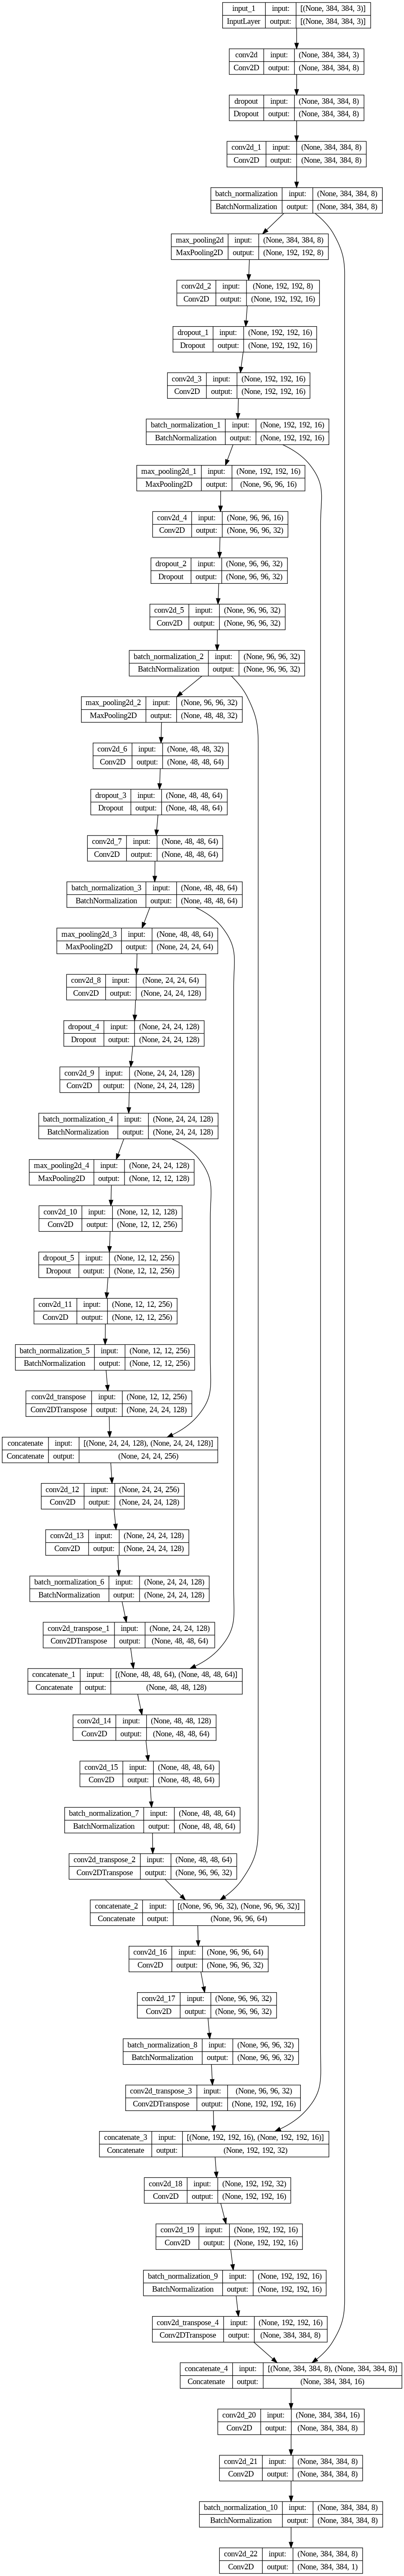

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

def lr_decay(epoch):
  return 0.1 * math.pow(0.766, epoch)

callback_learning_rate = LearningRateScheduler(lr_decay, verbose=1)

class EarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.05):
      print("\nReached 005%% value losse so cancelling training!")
      self.model.stop_training = True
        
early_stop = EarlyStop()  

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('dice_coef'))
        self.val_accuracy.append(logs.get('val_dice_coef'))
        self.i += 1

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(self.x, self.accuracy, 'r', label="dice_coef")
        ax1.plot(self.x, self.val_accuracy, 'bo', label="val_dice_coef")
        ax1.set_title('Model accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylim([0, 1])
        ax1.legend(['Train', 'Test'], loc='upper left')
         
        ax2.plot(self.x, self.losses, 'r', label="loss")
        ax2.plot(self.x, self.val_losses,'bo', label="val_loss")
        ax2.set_title('Model loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylim([0, 1])
        ax2.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        print(logs)
plot_losses = PlotLosses()

# tensorboard_log = TensorBoard(log_dir="./logs")  callback_learning_rate,

callbacks_list = [checkpoint]

In [20]:
train_df = train_df.dropna()
print(train_df.shape[0], ' masks found')
print(train_df['ImageId'].value_counts().shape[0], ' images found')

23995  masks found
12500  images found


In [21]:
unique_masks = train_df.drop_duplicates('ImageId')

In [22]:
from sklearn.model_selection import train_test_split
train_df_l, validate_df_l = train_test_split(unique_masks)

train_df_l = train_df[train_df['ImageId'].isin(train_df_l['ImageId'])]

In [23]:
validate_df_l = train_df[train_df['ImageId'].isin(validate_df_l['ImageId'])]

In [24]:
train_gen = make_image_gen(train_df_l)
validation_gen = next(make_image_gen(validate_df_l))

In [25]:
step_count = 25
history = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=10,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.9810 - dice_coef: 0.0190
Epoch 1: val_loss improved from inf to 0.99135, saving model to model_weights.best.hdf5
25/25 [==============================] - 206s 7s/step - loss: 0.9810 - dice_coef: 0.0190 - val_loss: 0.9913 - val_dice_coef: 0.0082
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.9753 - dice_coef: 0.0247
Epoch 2: val_loss did not improve from 0.99135
25/25 [==============================] - 162s 7s/step - loss: 0.9753 - dice_coef: 0.0247 - val_loss: 0.9915 - val_dice_coef: 0.0081
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.9709 - dice_coef: 0.0291
Epoch 3: val_loss improved from 0.99135 to 0.93429, saving model to model_weights.best.hdf5
25/25 [==============================] - 163s 7s/step - loss: 0.9709 - dice_coef: 0.0291 - val_loss: 0.9343 - val_dice_coef: 0.0611
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.9661 - dice_coef: 0.03

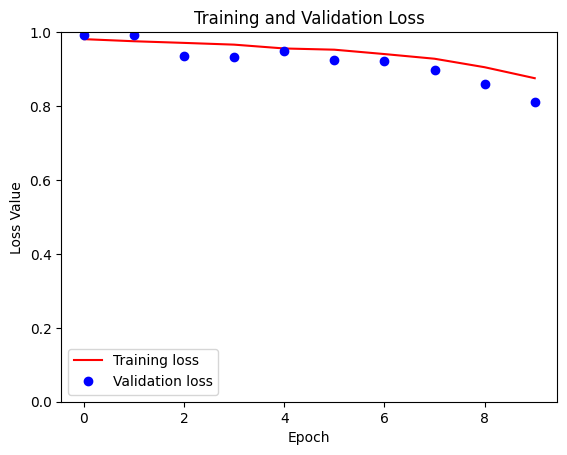

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [26]:
step_count = 25
history2 = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=10,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.8438 - dice_coef: 0.1562
Epoch 1: val_loss improved from 0.81029 to 0.74554, saving model to model_weights.best.hdf5
25/25 [==============================] - 162s 7s/step - loss: 0.8438 - dice_coef: 0.1562 - val_loss: 0.7455 - val_dice_coef: 0.2388
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.8036 - dice_coef: 0.1964
Epoch 2: val_loss did not improve from 0.74554
25/25 [==============================] - 165s 7s/step - loss: 0.8036 - dice_coef: 0.1964 - val_loss: 0.7580 - val_dice_coef: 0.2338
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.7575 - dice_coef: 0.2425
Epoch 3: val_loss improved from 0.74554 to 0.69262, saving model to model_weights.best.hdf5
25/25 [==============================] - 168s 7s/step - loss: 0.7575 - dice_coef: 0.2425 - val_loss: 0.6926 - val_dice_coef: 0.2896
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.6838 - dice_coef: 

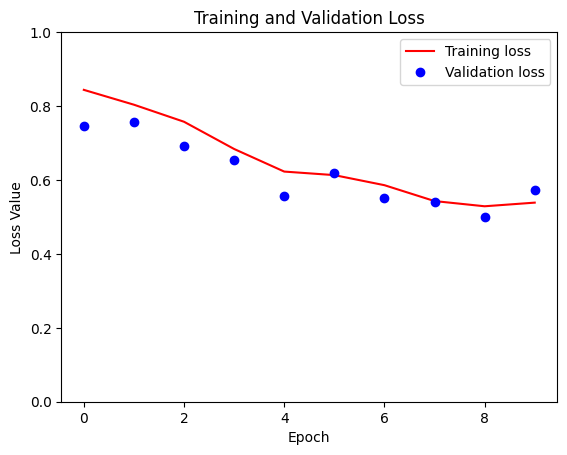

In [29]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [27]:
step_count = 25
history3 = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=10,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.5245 - dice_coef: 0.4755
Epoch 1: val_loss did not improve from 0.49935
25/25 [==============================] - 160s 7s/step - loss: 0.5245 - dice_coef: 0.4755 - val_loss: 0.5438 - val_dice_coef: 0.4332
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.4986 - dice_coef: 0.5014
Epoch 2: val_loss improved from 0.49935 to 0.49351, saving model to model_weights.best.hdf5
25/25 [==============================] - 166s 7s/step - loss: 0.4986 - dice_coef: 0.5014 - val_loss: 0.4935 - val_dice_coef: 0.4839
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.5318 - dice_coef: 0.4682
Epoch 3: val_loss did not improve from 0.49351
25/25 [==============================] - 164s 7s/step - loss: 0.5318 - dice_coef: 0.4682 - val_loss: 0.5485 - val_dice_coef: 0.4190
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.4866 - dice_coef: 0.5134
Epoch 4: val_loss did not improve from

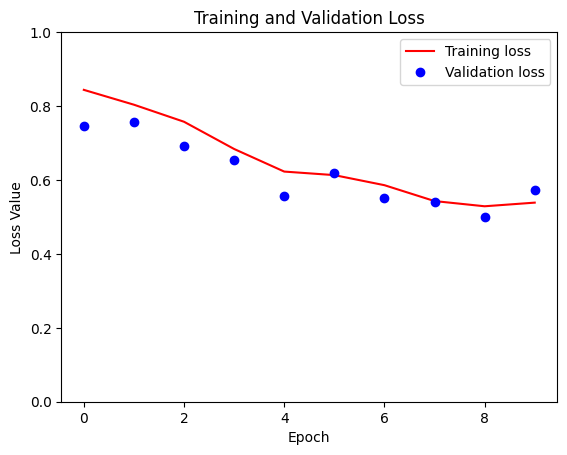

In [30]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure()
plt.plot(history3.epoch, loss, 'r', label='Training loss')
plt.plot(history3.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [31]:
step_count = 25
history4 = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=10,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.4870 - dice_coef: 0.5130
Epoch 1: val_loss improved from 0.48006 to 0.45618, saving model to model_weights.best.hdf5
25/25 [==============================] - 167s 7s/step - loss: 0.4870 - dice_coef: 0.5130 - val_loss: 0.4562 - val_dice_coef: 0.5169
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.4794 - dice_coef: 0.5206
Epoch 2: val_loss did not improve from 0.45618
25/25 [==============================] - 166s 7s/step - loss: 0.4794 - dice_coef: 0.5206 - val_loss: 0.5053 - val_dice_coef: 0.4819
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4658 - dice_coef: 0.5342
Epoch 3: val_loss improved from 0.45618 to 0.44896, saving model to model_weights.best.hdf5
25/25 [==============================] - 163s 7s/step - loss: 0.4658 - dice_coef: 0.5342 - val_loss: 0.4490 - val_dice_coef: 0.5347
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.4497 - dice_coef: 

In [32]:
step_count = 25
history5 = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=10,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.4447 - dice_coef: 0.5553
Epoch 1: val_loss did not improve from 0.44896
25/25 [==============================] - 163s 7s/step - loss: 0.4447 - dice_coef: 0.5553 - val_loss: 0.4846 - val_dice_coef: 0.4954
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.4473 - dice_coef: 0.5527
Epoch 2: val_loss did not improve from 0.44896
25/25 [==============================] - 168s 7s/step - loss: 0.4473 - dice_coef: 0.5527 - val_loss: 0.4732 - val_dice_coef: 0.5061
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4374 - dice_coef: 0.5626
Epoch 3: val_loss did not improve from 0.44896
25/25 [==============================] - 167s 7s/step - loss: 0.4374 - dice_coef: 0.5626 - val_loss: 0.5460 - val_dice_coef: 0.4256
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.4520 - dice_coef: 0.5480
Epoch 4: val_loss did not improve from 0.44896
25/25 [=============================

In [ ]:
step_count = 25
history5 = model.fit(train_gen,
                             steps_per_epoch=step_count,
                             epochs=5,
                             validation_data=validation_gen,
                             callbacks=callbacks_list)

Epoch 1/5
15/25 [=================>............] - ETA: 1:06 - loss: 0.4583 - dice_coef: 0.5417

In [ ]:
# step_count = 25
# history2 = model.fit(train_gen,
#                              steps_per_epoch=step_count,
#                              epochs=100,
#                              validation_data=validation_gen,
#                              callbacks=callbacks_list)

In [ ]:
# model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])